In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import spacy
import re
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer

print(tf.__version__)

2.1.0


## Instantiate BERT Model and Tokenizer

In [2]:
bert_model = TFBertModel.from_pretrained('bert-large-uncased')  # Automatically loads the config
bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

## Load Data

In [3]:
# Load data

train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sub_sample = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

print(train.shape, test.shape, sub_sample.shape)
train.head()

(7613, 5) (3263, 4) (3263, 2)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Text Preprocessing

#### Note: The performance was worse with preprocessing. Potentially a different preprocessing method would work better. In any case, I commented it out in the final version of this model training.

In [4]:
# # Remove contractions from words
# def decontracted(phrase):
#     # Specific
#     phrase = re.sub(r"won\'t", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # General
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
    
#     return phrase

In [5]:
# nlp = spacy.load('en')

# def preprocessing(text):
#   text = text.replace('#','') # Remove hashtags
#   text = decontracted(text) # Remove contractions
#   text = re.sub('\S*@\S*\s?','',text) # Remove '@', '*' and '?'
#   text = re.sub('http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)

#   token = []
#   result = ''
#   text = re.sub('[^A-z]', ' ',text.lower())
  
#   text = nlp(text)
#   for t in text:
#     if not t.is_stop and len(t)>2:  
#       token.append(t.lemma_)
#   result = ' '.join([i for i in token])

#   return result.strip()

In [6]:
# # Apply text pre-procesing and inspect a few examples
# train.text = train.text.apply(lambda x : preprocessing(x))
# test.text = test.text.apply(lambda x : preprocessing(x))
# train.head()

## Tokenize Text Using BertTokenizer

The following function will tokenize the words in each text entry, as well as perform the following functions:

* Add special tokens - [CLS] and [SEP]
* Create token IDs
* Pad the sentences to a common length
* Create attention masks for the above pad tokens

In [7]:
def bert_encode(data, maximum_length):
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.text)):
      encoded = bert_tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids), np.array(attention_masks)

In [8]:
max_len = 60 # Sentences will be padded with 0's to match length 60
train_input_ids, train_attention_masks = bert_encode(train, max_len)
test_input_ids, test_attention_masks = bert_encode(test, max_len)

## Compile Model

In [9]:
def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=6e-6)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

In [10]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 60, 1024), ( 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]          

## Train BERT Model on Disaster Tweets

In [11]:
BATCH_SIZE = 32
EPOCHS = 6
history = model.fit([train_input_ids,train_attention_masks],train.target,validation_split=0.05, epochs=EPOCHS,batch_size=BATCH_SIZE)

Train on 7232 samples, validate on 381 samples
Epoch 1/6
7232/7232 [==============================] - 197s 27ms/sample - loss: 0.5296 - accuracy: 0.7453 - val_loss: 0.3962 - val_accuracy: 0.8294
Epoch 2/6
7232/7232 [==============================] - 170s 24ms/sample - loss: 0.4040 - accuracy: 0.8357 - val_loss: 0.3553 - val_accuracy: 0.8399
Epoch 3/6
7232/7232 [==============================] - 170s 23ms/sample - loss: 0.3647 - accuracy: 0.8525 - val_loss: 0.3584 - val_accuracy: 0.8556
Epoch 4/6
7232/7232 [==============================] - 170s 23ms/sample - loss: 0.3316 - accuracy: 0.8675 - val_loss: 0.3626 - val_accuracy: 0.8373
Epoch 5/6
7232/7232 [==============================] - 170s 23ms/sample - loss: 0.3019 - accuracy: 0.8843 - val_loss: 0.4015 - val_accuracy: 0.8451
Epoch 6/6
7232/7232 [==============================] - 170s 23ms/sample - loss: 0.2665 - accuracy: 0.8992 - val_loss: 0.4911 - val_accuracy: 0.8346


## Predictions and Submission

In [12]:
# Generate predictions for test dataset
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)

In [13]:
result = pd.DataFrame(result)
output = pd.DataFrame({'id':sub_sample.id,'target':result[0]})
output.to_csv('submission.csv',index=False)

## Plot Learning

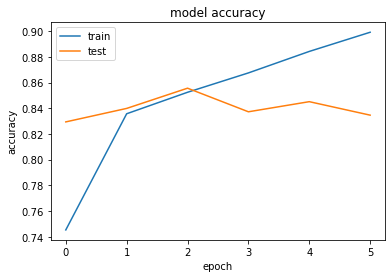

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

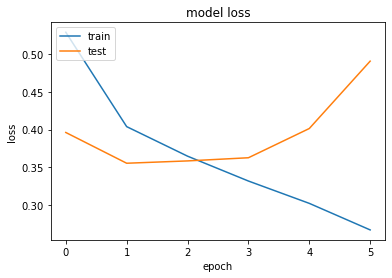

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()